# A/B Testing - Analysis and Results

**Caleb Pitts, 7/29/18**

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

I am assuming the fictitious role of Principle Data Scientist at X Corporation. I collected a dataset of nearly 300,000 users who either visited X Corporation's main website or new test website. The dataset also shows whether a user "converted," which means they bought something off the website.

Given this dataset, I've outlined a statistical representation showing whether the new test website has a higher conversion rate than the old main website. 

Before I spoil the mystery however, I want to show how I arrived at my conclusion. First, I will examine the conversion rates in the expiremental and control groups. I will also add conditional probalities of conversion under certain conditions. Then, I will simulate many random samplings with replacement (bootstrapping) to calculate a p-value that provides insight as to whether the difference in conversion rates is significant. Finally, I will use logistic regression to determine the relationship between variables and whether each explanatory variable is significant enough to predict the response variable (conversion rate). 

This company and dataset are fictitious and more of a fun exercise for me.

<a id='probability'></a>
#### Part I - Probability


In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Reading 'ab_data.csv' into the Pandas DataFrame 'df'
df = pd.read_csv('ab_data.csv')

In [4]:
# Here's a view of how the dataframe is structured.
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [5]:
# There are 294,478 rows in this dataset.
df.shape

(294478, 5)

In [6]:
# There are 290,584 unique users in this dataset.
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

In [7]:
# Here is the proportion of users converted.
# A user is 'converted' when they buy a product on the website.
user_conversion_rate = df['converted'].mean()*100

#The user conversion rate is 11.96%, meaning about 12% of users purchased something regardless of the webpage version.
print(user_conversion_rate)

11.96591935560551


In [8]:
# I am measuring the number of times the new_page and treatment don't line up to identify any errors.
# Every user in the treatment group needs to have a their landing page be the new page.
treatment_mismatch = df[((df['group'] == "treatment") == (df['landing_page'] == "old_page")) == True]

In [9]:
# There are 3,893 users in the experiment group that did not get the new page.
treatment_mismatch.shape

(3893, 5)

In [10]:
# There are no missing values since the sum of null values is 0 for every column.
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [11]:
# I am going to drop the rows in which the experiment/contol group don't match with their respective web pages, 
# because I am not confident in the accuracy of that part of the data.
# I am placing the dataframe with the dropped rows in a new dataframe named 'df2'
df2 = df[((df['group'] == "treatment") == (df['landing_page'] == "old_page")) == False]

In [12]:
# I am making sure that there are no longer any treatment mismatches in the dataset.
# There are no discrepencies now because the result is 0.
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [13]:
# There are now 290,584 unique users in the second dataframe.
df2['user_id'].nunique()

290584

In [14]:
# I am collecting any duplicated users and placing them in a new dataframe named 'rdf'
rdf = df2[df2['user_id'].duplicated()]

# There is only one duplicated row in the entire dataset. The duplicated row is at index 2893.
rdf.index

Int64Index([2893], dtype='int64')

In [15]:
# Here is the data in the duplicated row.
rdf

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [16]:
# I am going to drop the duplicate row, because we only want to measure unique visitors to the site.
df2 = df2.drop_duplicates(subset=['user_id'])

In [17]:
# Checking whether there are any duplicated rows after calling drop_duplicates.
df2['user_id'].duplicated().any()

False

In [18]:
# The probability of an individual converting regardless of the page they receive.
# Approximately 12%
df2['converted'].mean()*100

11.959708724499627

In [19]:
# Given that an individual was in the control group, the probability they converted is 12.04%.
df2.query('group == "control"')['converted'].mean()*100

12.03863045004612

In [20]:
# Given that an individual was in the treatement group, the probability they converted is 11.88%
df2.query('group == "treatment"')['converted'].mean()*100

11.880806551510565

In [21]:
# The total probability that an individual received the new page is 50.01%
(df2.query('landing_page == "new_page"').shape[0]/df2.shape[0])*100

50.00619442226688

**Based on the difference in conversion rates given their group type, there is not enough evidence to suggest that the new treatment page leads to more conversions. There is only a 1/10 difference between each conversion rate, which is not practically significant. I also need to know whether the statistics I gathered above actually represents the whole population in a significant way. So, I will run an A/B test with null and alternative hypothesis to find out if my statistics are significant.**

<a id='ab_test'></a>
### Part II - A/B Test

I am going to run an A/B test be stating my hypothesis and running simulations under the null to determine the signifigance of our observed statistics. This should give me a better idea as to whether the new web page has a significant affect on conversion rate. 

**Lets say that **$p_{old}$** represents the proportion of users that convert (buy something) on the old site and **$p_{new}$** represents the propotion of users that convert on the new site.**

**Now lets say that the null hypothesis is that  **$p_{old}$** is greater than or equal to **$p_{new}$**, and the alternative hypothesis is that **$p_{old}$** is less than **$p_{new}$**. The null hypothesis says that the conversion rate for the old web page will be greater than or equal to the conversion rate of the new web page. The alternative hypothesis says that the new web page has a higher conversion rate than the old web page.**

In [22]:
# I want to figure out what the conversion rate for each web page style under the null. 
# If we assume that under the null, the conversion rate is the same no matter the page type,
# then we just compute the overall conversion rate.
p_new = df2['converted'].mean()
p_new

0.11959708724499628

In [23]:
# Same thing for the old web page style since web page style doesn't affect the conversion rate under the null.
p_old = df2['converted'].mean()
p_old

0.11959708724499628

In [24]:
# Now I am collecting the number of users who experienced the new web page and storing all the rows in 'n_new'.
# I will use this as the size I will use for each of my random samples when I assemble a sampling distribution.
n_new = df2.query('landing_page == "new_page"')
n_new.shape[0]

145310

In [25]:
# Same thing for the old web page. 
n_old = df2.query('landing_page == "old_page"')
n_old.shape[0]

145274

In [26]:
# Here I am calculating the observed difference from the raw dataset with no simulations.
# This will form the basis of my comparison with the simulated conversion differences that I will use to determine significance.
obs_new = df2.query('landing_page == "new_page"')['converted'].mean()
obs_old = df2.query('landing_page == "old_page"')['converted'].mean()
obs_diff = obs_new - obs_old
obs_diff

-0.0015782389853555567

In [27]:
# I am building a random binomial distribution of the size of n_new and the convert rate p_new 
# which is the same as p_old under the null hypothesis.
new_page_converted = np.random.binomial(1, p_new, n_new.shape[0])

In [28]:
# Now I am doing the same thing for the old web page.
old_page_converted = np.random.binomial(1, p_old, n_old.shape[0])

In [29]:
# Here is the simulated difference of the conversion rate between the old and new web page.
# I took the mean of each binomial distribution that I generated above.
sim_diff = old_page_converted.mean() - new_page_converted.mean()
sim_diff

-0.0003147186157156784

In [30]:
# Now I am doing the same thing I did above, but 10,000 times. This will ensure a normally distributed
# conversion difference histogram. Then, I am generating a normal distribution that reflects our
# null hypothesis, by providing what the standard deviation should be if the null were true. 
p_diffs = np.random.binomial(n_new.shape[0], p_new, 10000)/n_new.shape[0] - np.random.binomial(n_old.shape[0], p_old, 10000)/n_old.shape[0]

null_values = np.random.normal(0, np.array(p_diffs).std(), len(p_diffs))

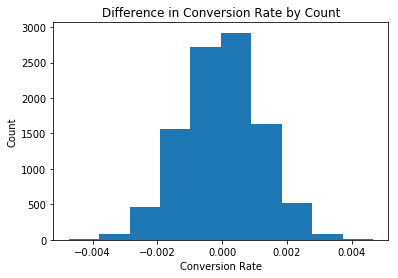

In [31]:
# Now I am going to plot all the simulated differences in conversion rate on a histogram.
# Below, we see a normal distribution, confirmed by the central limit theorem. 
plt.hist(np.array(p_diffs))
plt.title("Difference in Conversion Rate by Count")
plt.xlabel("Conversion Rate")
plt.ylabel("Count");

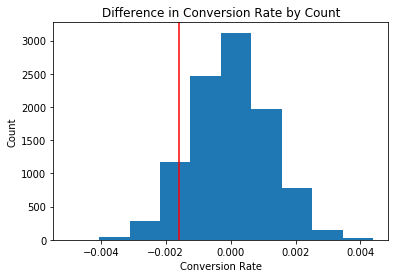

In [32]:
# I am now plotting a histogram of the null values that are associated with the null hypothesis. 
# If our observed value is very different from this histogram, then we consider rejecting the null.
# The red line shows our observed difference in conversion from the raw data.
plt.hist(null_values)
plt.axvline(obs_diff, c='red')
plt.title("Difference in Conversion Rate by Count")
plt.xlabel("Conversion Rate")
plt.ylabel("Count");

In [33]:
# Now I am calculating the percentage of the null_values that are above our observed difference in conversion rate. 
# This gives us our p-value to determine whether our observed statistic is significant.
(np.array(null_values) > obs_diff).mean()

0.9038

**The value above gives us the p-value of our null distribution. This tells us the probability that the statistic that we observed occurred due to the null hypothesis being true. If the p-value was less than an assumed alpha level of 0.05, then we would assume that the observed statistic is not from the null, therefore favoring the alternative hypothesis. However, our statistic's p-value is significantly higher than our chosen alpha level, thus we fail to reject the null hypothesis. This gives us evidence to stick with the current web page design.**

In [34]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page"')['converted'].sum()
convert_new = df2.query('landing_page == "new_page"')['converted'].sum()
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]

In [35]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.9050583127590245)

**The z-score is the number of standard deviations the data point is from the mean. The p-value agrees with the finding stated above, because it is greater than a 0.05 significance level. Thus, both tests agree to fail to reject the null hypothesis, meaning we must assume the old web page has a greater or equal conversion rate compared to the new web page.** 

<a id='regression'></a>
### Part III - Logistic Regression Approach

**We should perform logistic regression since we are only measuring conversion rates and how web page types affect those conversion rates. Those web types or control/expiremental groups are categorical. Thus, we must use logistic regression since categorical variables are limited in their numerical value.**

In [36]:
# I am creating a dummy variable for the intercept and groups where the column ab_page is 1 
# if its part of the treatment group, and 0 if its part of the control group. 
df2['intercept'] = 1
dummy = pd.get_dummies(df2['group'])
df2['ab_page'] = np.where(dummy['treatment']==1, 1, 0)

In [37]:
# Now using statsmodels, I am going to run a simple linear regression model to determine how 'ab_page' affects 'converted'.
logim = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
result = logim.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [38]:
# Here is a summary of the results. 'coef' stands for every one unit increase in 'ab_page', the 'converted' rate 
# would decrease 0.0016.
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 26 Aug 2018   Pseudo R-squ.:               8.077e-06
Time:                        21:23:42   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

**The p-value associated with ab_page is 0.19, which differs greatly from the 0.9 p-value found in the A/B test. The A/B test was concerned with what page had the higher conversion rate, so we used a one-tailed test when calculating the p-value. On the other hand, logistic regression is concerned with whether the new page had any effect on conversion rate at all, so we use a two-tailed test. The different tests results in different p-values that reflect different null hypothesis.**

**The logistic regression model suggests there is no relationship between conversion rate and the different web pages since the p-value is above our alpha level of 0.05.**

**It's a good idea to consider other factors to add in our regression model because it tells us whether there are multiple variables affecting the response variable or if its just one. This helps us identify any confounding variables and gives us a better picture of what explanatory variables affect the response variable the most.**

**Now I am going to add an effect based on which country the user lives. I'd like to explore whether an individual's location effects their conversion rate. Then I am going to determine whether a user's conversion rate is affected by an interaction between web page type and location.**

In [39]:
# Here I am loading in the data that indicates the country that the user is viewing the page from.
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [40]:
# Now I am going to create dummy variables for each country since counties are categorical, not numerical data.
# Then I will add each dummy variable to the 'df_new' dataframe.
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])

In [41]:
# Here is what the dataframe looks like now with the dummy variables at the end.
# 1 represents that is the country and 0 represents that it is not that country.
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [42]:
# I am using Logistic Regression since this measures categorical variables and the numeric data is not infinite.
# I am only including 3 of the 4 dummy variables since the 4th dummy variable is implied by the others.
logi = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'CA', 'UK']])
logi_result = logi.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [43]:
# Here is a summary of the results of the logistic regression model.
logi_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sun, 26 Aug 2018   Pseudo R-squ.:               2.323e-05
Time:                        21:23:44   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

In [44]:
# Now I am going to measure the interaction between page and country by multiplying ab_page type and country presence.
df_new['CA_interaction'] = df_new['CA']*df_new['ab_page']
df_new['UK_interaction'] = df_new['UK']*df_new['ab_page']
df_new['US_interaction'] = df_new['US']*df_new['ab_page']

In [45]:
# Here is what the added columns look like.
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,CA_interaction,UK_interaction,US_interaction
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,0,1,0


In [46]:
# Finally, I will model this dataframe using logistic regression on each of the interactions.
# I will leave at US_interaction since it is implied by the other two interaction columns.
logi_interaction = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'CA_interaction', 'UK_interaction']])
logi_interaction_result = logi_interaction.fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


In [47]:
# Here is the summary of the logistic regression of the interacting variables.
logi_interaction_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sun, 26 Aug 2018   Pseudo R-squ.:               3.351e-05
Time:                        21:23:45   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                   0.06785
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept         -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page           -0.0183      0.013     -1.449      0.147      -0.043       0.006
CA_interaction    -0.0644      0.038     -1.679      0.093      -0.140       0.011
UK_interaction     0.0257      0.019      1.363      0.173      -0.011       0.063
==================================================================================
"""

**The larger p-value for UK_interaction indicates that there is a greater chance that the different web pages have no effect on conversion rate in the UK as opposed to Canada. There is a lower p-value for Canada, but it is still above our alpha level, suggesting that none of the different locations have a significant effect or interaction with conversion rate.**

<a id='conclusions'></a>
## Conclusions

I approached my analysis in 3 different ways. The first way was not a model but rather a quick inspection of the observed difference in conversion rate. The observed proportions were only a statistic and may have not been representative of the whole population. 

So, I performed a t-test to see how accurate my observed statistic was. The t-test concluded that we cannot reject the null hypothesis due to the observed statistic being inline with the null distribution (p-value > 0.05). This meant that the simulated differences in conversion rates did NOT show that the new web page had a significantly higher conversion rate than the old web page.

Then I decided to take a logistic approach to see if there was any correlation at all between the conversion rates and web page version. I found that the the p-value corresponding to the difference in conversion rates was still above 0.05, suggesting that the web page version type had no significant effect on conversion rate. I had the same conclusion when I tested whether specific countries affected conversion rate when a user saw the old or new website. The p-value was still roughly the same for the countries included in the countries.csv dataset. This con

Overall, since we cannot reject our null hypothesis in both approaches, I am confident in saying I CANNOT find any evidence suggesting that the new web page is better. Thus, I would recommend that the company should stay with the current website to avoid any risk in going with the new site. Practically, we need to have a much more significant difference in conversion rate to even think about going to the new website.